In [1]:
import time
import copy
import os
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

## Part 1 -- Data

In [2]:
dir_data = '/home/hhg/Research/emu_Nx2pt/data/'
filename = dir_data+'pco_train_1000000.pkl'
startID, endID = 0, 100000

with open(filename, 'rb') as handle:
    pco_samples = pickle.load(handle)

df_pco = pd.DataFrame(pco_samples).iloc[startID:endID]
df_pco.head()

,Omega_m,sigma_8,Omega_b,n_s,h
0,0.283464,0.806686,0.048275,0.978520,0.671642
1,0.225333,0.835896,0.044694,0.928571,0.796949
2,0.226897,0.837364,0.048245,0.976088,0.794540
3,0.384316,0.847758,0.047460,0.972288,0.627548
4,0.355954,0.820324,0.043157,0.988147,0.738776


In [3]:
Nsamples = len(df_pco['Omega_m'])
sampleID = list(range(Nsamples))

trainID, validID = train_test_split(sampleID, train_size=0.7, random_state=0)

In [4]:
class datavDataset(Dataset):
    
    def __init__(self, IDs, df_pco, dir_datav, transform=None):
        self.IDs = IDs
        self.dir_datav = dir_datav
        self.df_pco = df_pco
        
    def __getitem__(self, index):
        pcoID = self.IDs[index]
        dataT = torch.load( os.path.join(self.dir_datav, 'dataT_'+str(pcoID)+'.pt') )
        pco = torch.from_numpy(df_pco.iloc[[pcoID]].values[0]).float()
        return pco, dataT
    
    def __len__(self):
        return len(self.IDs)

In [5]:
dir_datav = '/home/hhg/Research/emu_Nx2pt/data/train_1M/'

dataset = {}
dataset['train'] = datavDataset(trainID, df_pco, dir_datav)
dataset['valid'] = datavDataset(validID, df_pco, dir_datav)

In [6]:
batch_size = 64

dataloader = {}
dataloader['train'] = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
dataloader['valid'] = DataLoader(dataset['valid'], batch_size=batch_size, shuffle=True)

In [7]:
validSamples = iter(dataloader['valid'])
pco, datav = validSamples.next()
Nout = len(datav[0])

## Part 2 -- Model

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# Device configuration 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Npco = 5
Nhidden1 = 64
Nhidden2 = 64
Nout = Nout

class SimpleNet(nn.Module):
    
    def __init__(self, Npco, Nout, Nhidden1, Nhidden2):
        super().__init__()
        self.fc1 = nn.Linear(in_features=Npco, out_features=Nhidden1)
        self.fc2 = nn.Linear(in_features=Nhidden1, out_features=Nhidden2)
        self.fc3 = nn.Linear(in_features=Nhidden2, out_features=Nout)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
class ChiSquare(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, predicted, actual):
        chi2 = ((predicted - actual) ** 2).sum() # mse = ((predicted - actual) ** 2).mean()
        return chi2

In [10]:
# ------ Hyper-parameters ------ 
num_epochs = 50
batch_size = batch_size
learning_rate = 0.1
step_size = 10
gamma = 0.1
early_stop_threshold = 10

########################

model = SimpleNet(Npco=Npco, Nout=Nout, Nhidden1=Nhidden1, Nhidden2=Nhidden2).to(device)

#criterion = nn.MSELoss()
criterion = ChiSquare()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

## Part 3 -- Training & Validation

In [11]:
current_epoch = 0
best_epoch    = 0
best_model_wts = copy.deepcopy(model.state_dict())
min_valid_loss = np.inf

save_key = ['train_loss', 'valid_loss', 'epoch_train_loss', 'epoch_valid_loss', 'lr']
trainInfo = {key:[] for key in save_key}

for epoch in range(num_epochs):
    current_epoch = epoch
    
    # ---------------------------------
    # ------ START TRAIN 1 EPOCH ------
    # ---------------------------------
    
    since = time.time()
    
    print(f'Epoch {current_epoch+1}/{num_epochs}')
    for phase in ['train', 'valid']:
        
        if phase == 'train': 
            model = model.train()
        else:
            model = model.eval()
        
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader[phase]):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
            trainInfo[f'{phase}_loss'].append( loss.item()/inputs.size(0) )
            
            running_loss += loss.item()
        
        # ------ End training the epoch in a train or valid phase ------
        
        epoch_loss = running_loss / len(dataset[phase])
        trainInfo[f'epoch_{phase}_loss'].append(epoch_loss)
        
        print(f'\t{phase} avg_chi2: {epoch_loss:.2f}', end='')
        
        
        if phase == 'train':
            scheduler.step()

        if phase == 'valid':
            if epoch_loss < min_valid_loss: # -> deep copy the model
                best_epoch = current_epoch
                min_valid_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
              
    # ------ End training the ephch in both train & valid phases ------
    trainInfo['lr'].append(scheduler.get_last_lr()[0]) # save lr / epoch
    time_cost = time.time() - since
    print(f'\tTime: {time_cost//60:.0f}m {time_cost%60:.0f}s')    
    
    # -------------------------------
    # ------ END TRAIN 1 EPOCH ------
    # -------------------------------
    
    if current_epoch - best_epoch >= early_stop_threshold:
        print(f'Early stopping... (Model did not imporve after {early_stop_threshold} epochs)')
        break

print(f'\nMinimum (epoch-averaged) validation loss reached at epoch {best_epoch+1}.')

Epoch 1/50
	train avg_chi2: 13295.34	valid avg_chi2: 4566.54	Time: 0m 26s
Epoch 2/50
	train avg_chi2: 2890.91	valid avg_chi2: 932.21	Time: 0m 26s
Epoch 3/50
	train avg_chi2: 1279.34	valid avg_chi2: 350.72	Time: 0m 26s
Epoch 4/50
	train avg_chi2: 1071.14	valid avg_chi2: 312.53	Time: 0m 26s
Epoch 5/50
	train avg_chi2: 729.60	valid avg_chi2: 268.71	Time: 0m 26s
Epoch 6/50
	train avg_chi2: 760.54	valid avg_chi2: 543.97	Time: 0m 26s
Epoch 7/50
	train avg_chi2: 674.48	valid avg_chi2: 217.17	Time: 0m 26s
Epoch 8/50
	train avg_chi2: 618.28	valid avg_chi2: 213.77	Time: 0m 26s
Epoch 9/50
	train avg_chi2: 576.42	valid avg_chi2: 254.20	Time: 0m 26s
Epoch 10/50
	train avg_chi2: 643.46	valid avg_chi2: 127.42	Time: 0m 26s
Epoch 11/50
	train avg_chi2: 99.91	valid avg_chi2: 95.85	Time: 0m 26s
Epoch 12/50
	train avg_chi2: 88.82	valid avg_chi2: 83.37	Time: 0m 27s
Epoch 13/50
	train avg_chi2: 76.20	valid avg_chi2: 89.07	Time: 0m 26s
Epoch 14/50
	train avg_chi2: 68.34	valid avg_chi2: 62.64	Time: 0m 26s
Epo

## Plots -- Training Process

In [12]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rc('font', size=16)

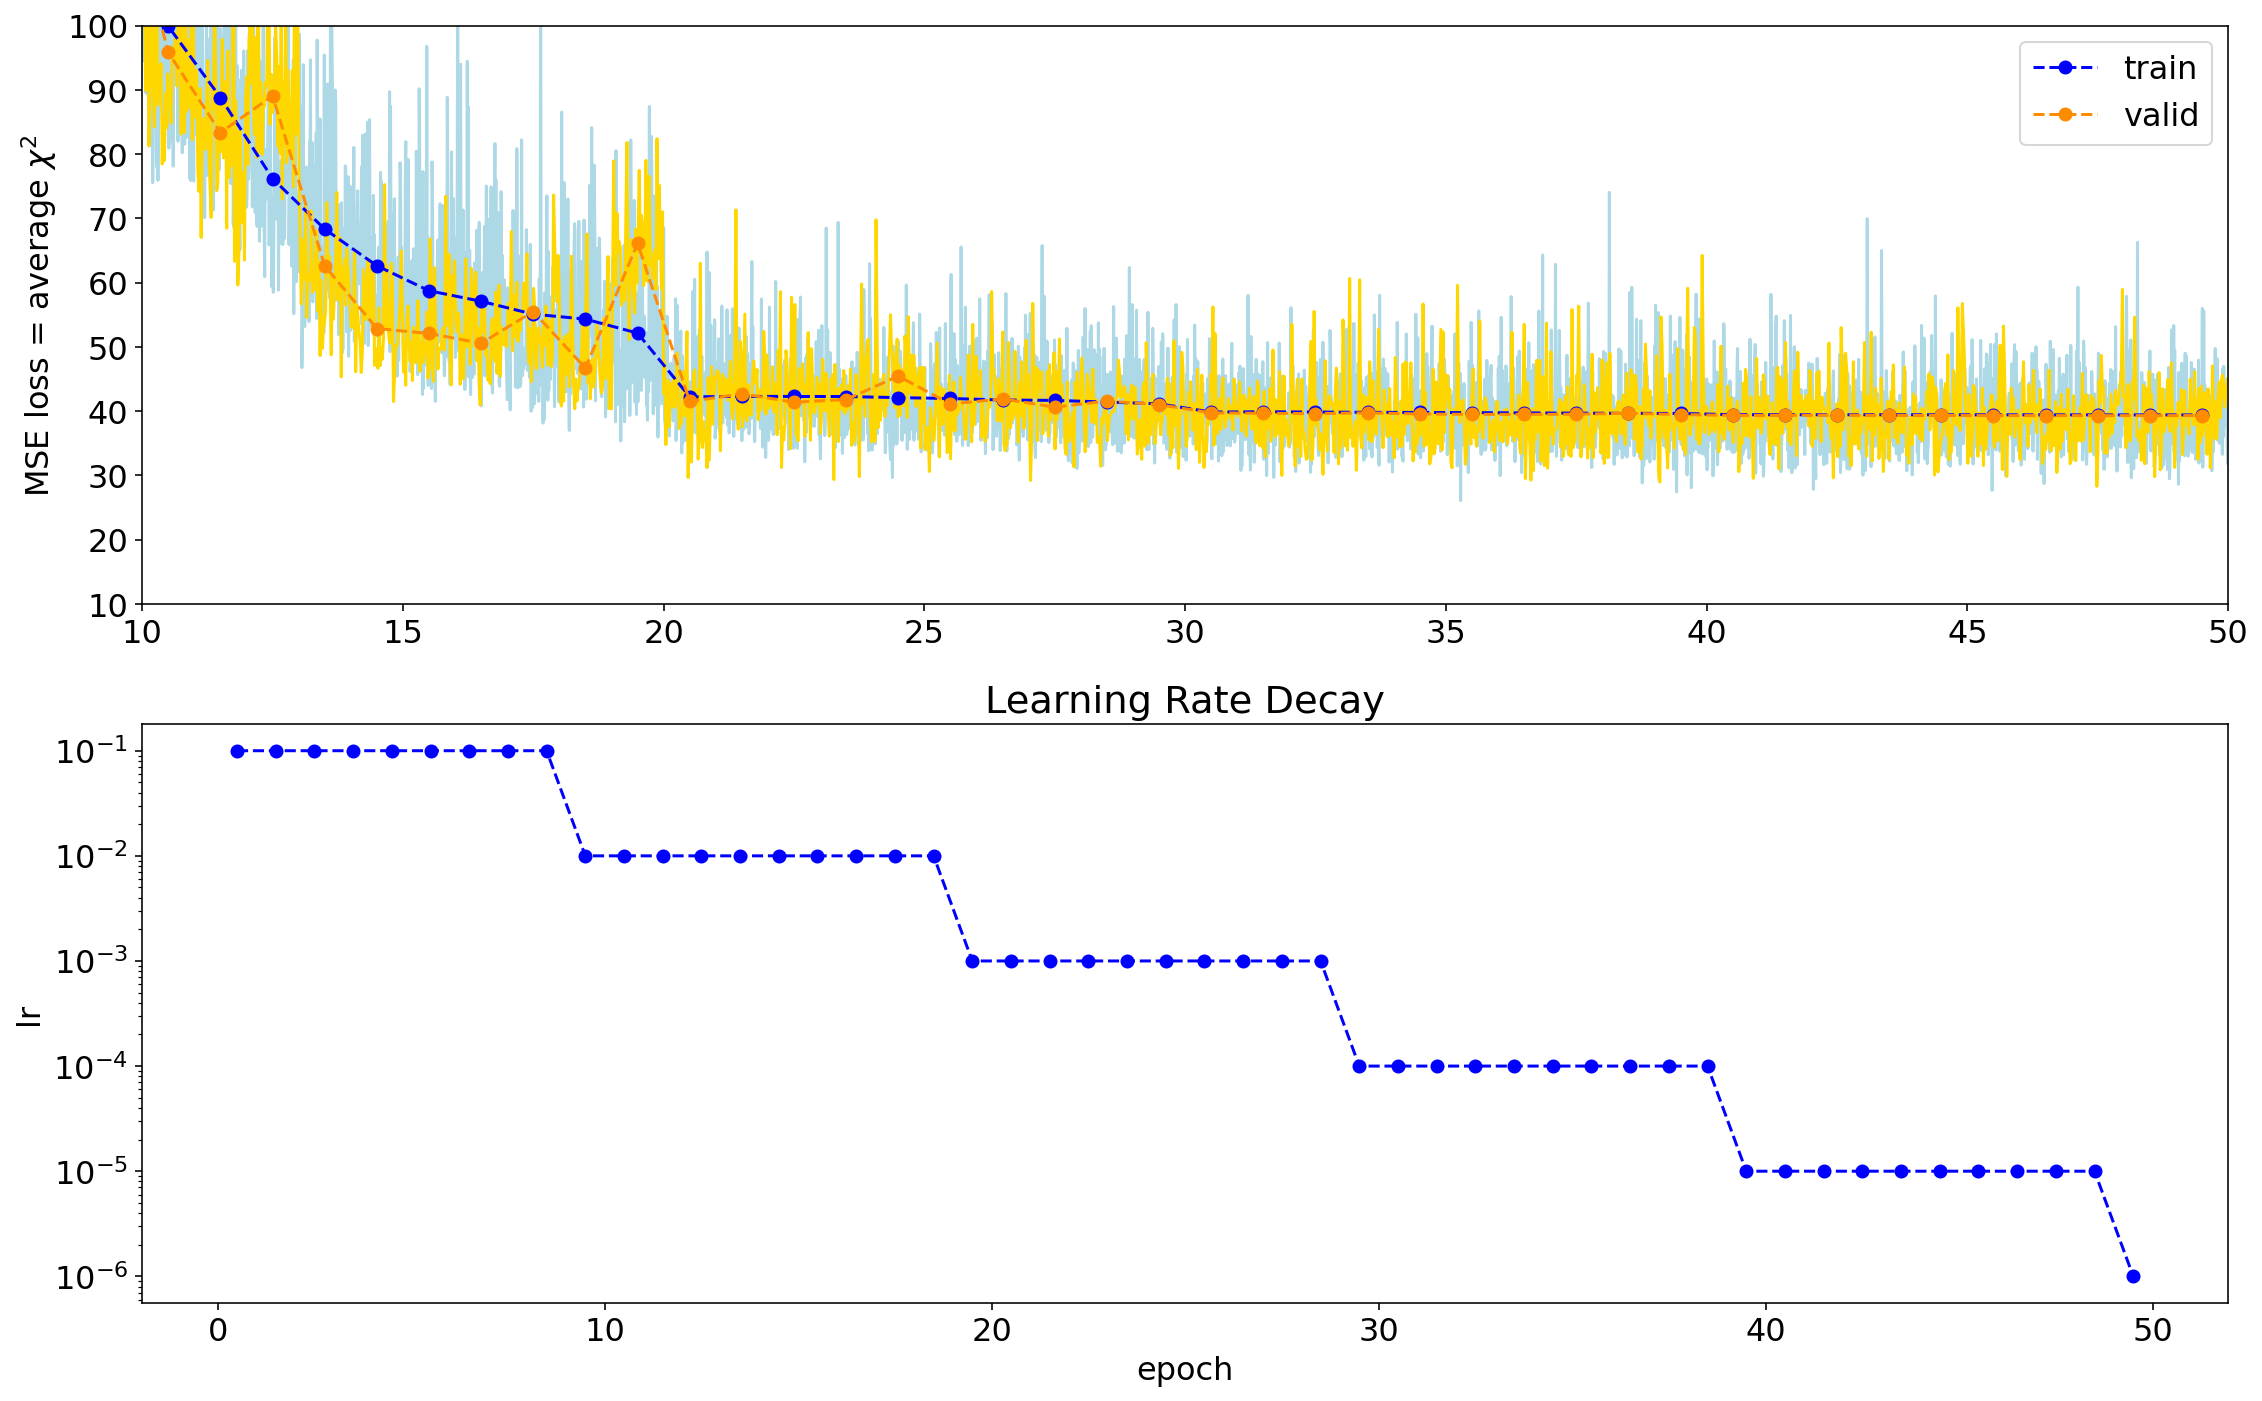

In [27]:
iter_tick = {}
for phase in ['train', 'valid']:
    iter_tick[phase] = np.array(range(len(trainInfo[f'{phase}_loss'])))/len(dataloader[phase])

epoch_tick = np.array(range(len(trainInfo['epoch_train_loss'])))+0.5

# --------------------------

plt.figure(figsize=(16,10))

plt.subplot(211)

n = 10
plt.plot(iter_tick['train'][::n], trainInfo['train_loss'][::n], color='lightblue')
plt.plot(iter_tick['valid'][::n], trainInfo['valid_loss'][::n], color='gold')

plt.plot(epoch_tick, trainInfo['epoch_train_loss'], 'o--', label='train', color='b')
plt.plot(epoch_tick, trainInfo['epoch_valid_loss'], 'o--', label='valid', color='darkorange')

plt.ylabel('MSE loss = average $\chi^2$')

plt.legend()

plt.xlim([10,50])
plt.ylim([10,100])


plt.subplot(212)
plt.plot(epoch_tick, trainInfo['lr'], 'o--', label='train', color='b' )
plt.title('Learning Rate Decay')
plt.ylabel('lr')
plt.yscale('log')
plt.xlabel('epoch')


plt.tight_layout()

## Plots -- Visualize the best-trained emulator

In [21]:
dvID = 30

validSamples = iter(dataloader['valid'])
with torch.no_grad():
    pco, datav = validSamples.next()
    pco = pco.to(device)
    
    datavT = datav.to(device)
    predictT = model(pco)
    
predict = predictT.to('cpu').numpy()
datav = datavT.to('cpu').numpy()

criterion_chi2 = ChiSquare()
chi2 = criterion_chi2(predictT[dvID], datavT[dvID]).to('cpu').numpy()

Text(0, 0.5, 'fractional difference')

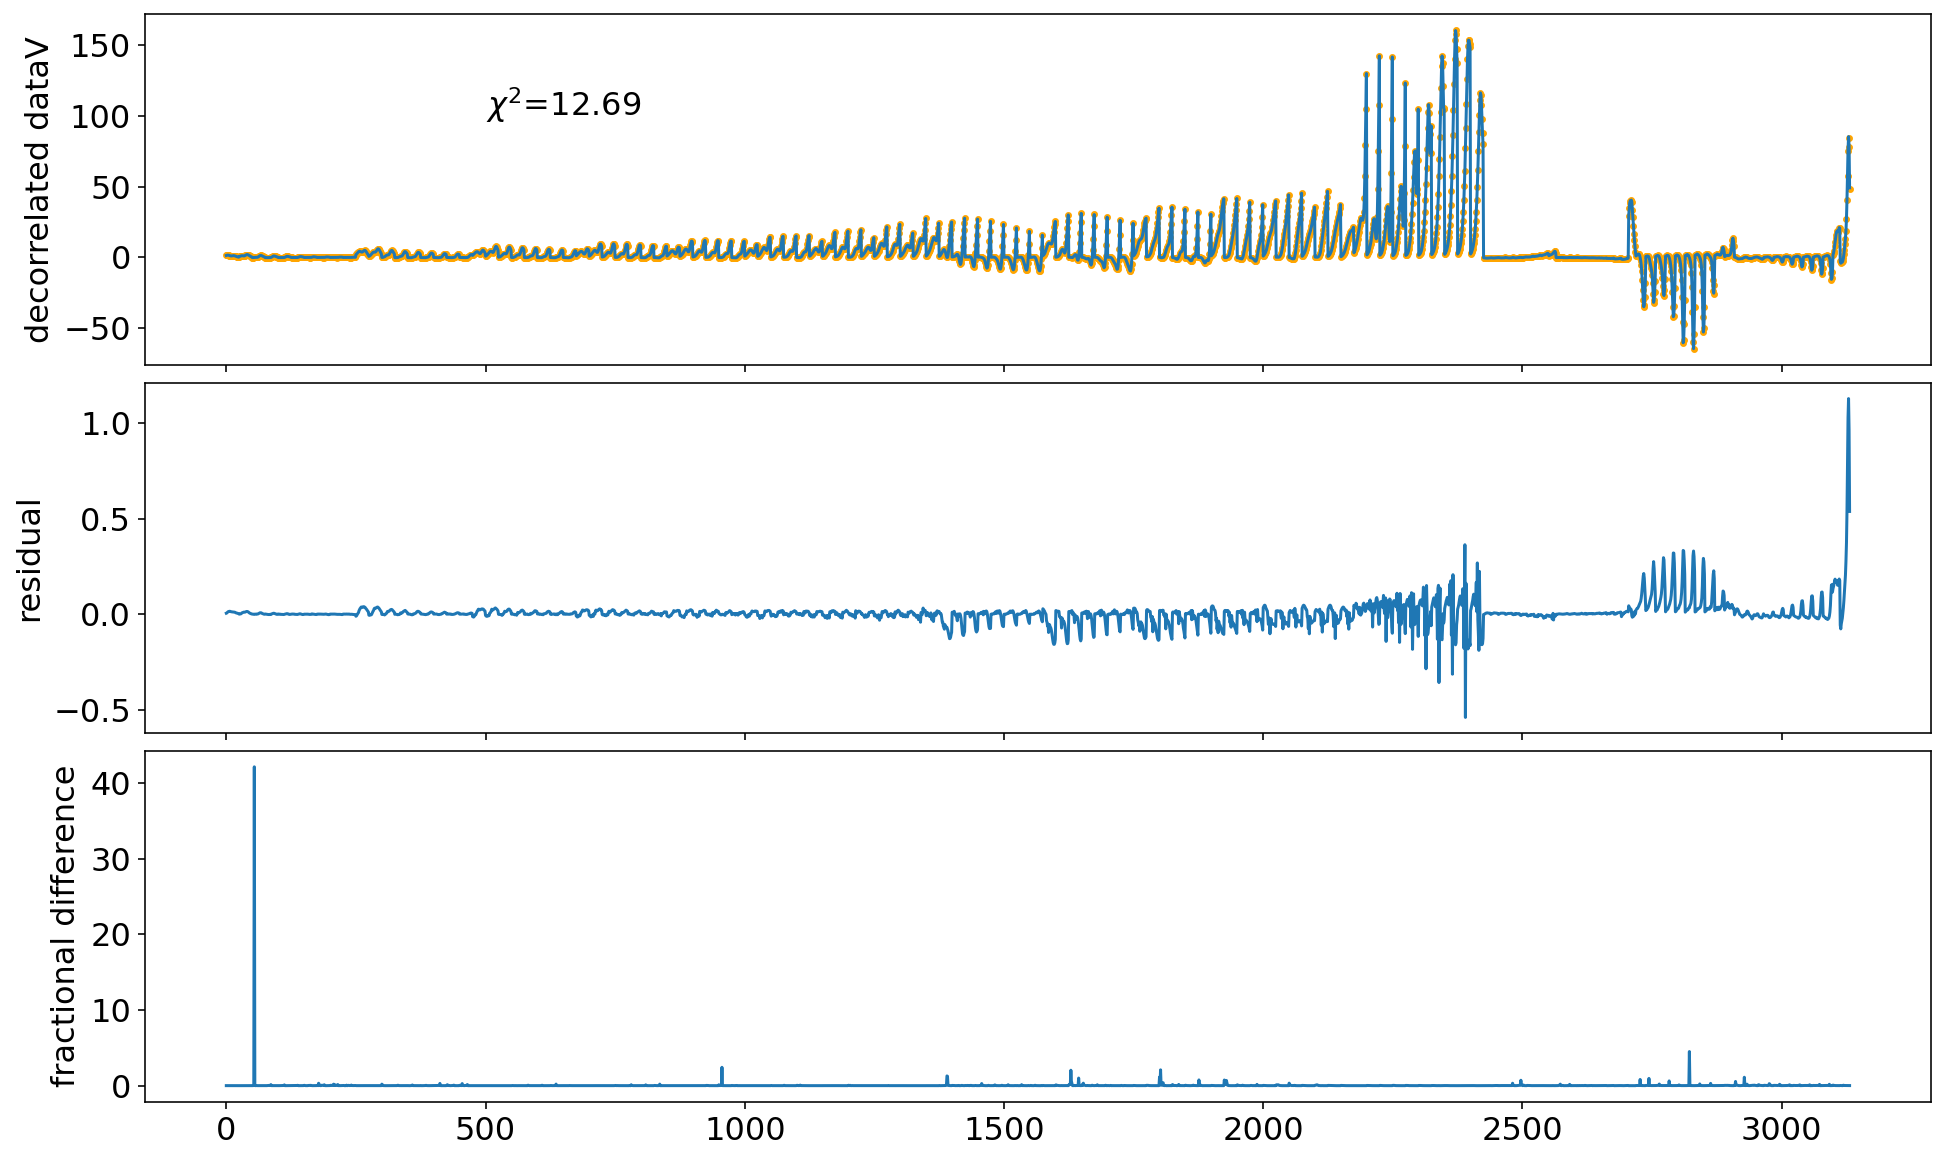

In [22]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(hspace=0.05)


plt.subplot(311)
plt.plot(range(0,len(datav[dvID])), datav[dvID])
plt.scatter(range(0,len(datav[dvID])), predict[dvID], s=6, color='orange')
plt.ylabel('decorrelated dataV')
plt.xticks(range(0,len(datav[dvID]), 500),[])
plt.text(500, 100, f"$\chi^2$={chi2:.2f}")

plt.subplot(312)
plt.plot( range(0,len(datav[dvID])), datav[dvID]-predict[dvID])
plt.ylabel('residual')
plt.xticks(range(0,len(datav[dvID]), 500),[])

plt.subplot(313)
plt.plot( range(0,len(datav[dvID])), abs(datav[dvID]-predict[dvID])/abs(datav[dvID]) )
plt.ylabel('fractional difference')

## Check in detail nn.MSELoss( ) v.s. ChiSquare( ) I defined. 

In [16]:
dvID = 30

validSamples = iter(dataloader['valid'])
with torch.no_grad():
    pco, datav = validSamples.next()
    pco = pco.to(device)
    
    datavT = datav.to(device)
    predictT = model(pco)


criterion_chi2 = ChiSquare()
criterion_mse  = nn.MSELoss()
    
loss_chi2 = criterion_chi2(predictT, datavT)
loss_mse  = criterion_mse(predictT, datavT)

In [17]:
predict = predictT.to('cpu').numpy()
datav = datavT.to('cpu').numpy()

chi2_arr = np.zeros(64)
mse_arr = np.zeros(64)
for i in range(64):
    diff = datav[i]-predict[i]
    chi2 = np.sum(diff**2)
    mse  = np.mean(diff**2)
    chi2_arr[i] = chi2
    mse_arr[i] = mse

In [18]:
loss_chi2, chi2_arr.sum()

(tensor(50994.6875, device='cuda:0'), 50994.68475341797)

In [19]:
loss_mse, mse_arr.mean()

(tensor(0.2544, device='cuda:0'), 0.25440356036415324)

In [20]:
criterion_chi2(predictT[30], datavT[30])

tensor(1274.3003, device='cuda:0')

In [21]:
chi2_arr[30]

1274.30029296875

## Back Ups

In [ ]:
def train_one_epoch():
    since = time.time()
    
    print(f'Epoch {current_epoch+1}/{num_epochs}')
    for phase in ['train', 'valid']:
        
        if phase == 'train': 
            model = model.train()
        else:
            model = model.eval()
        
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader[phase]):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
            trainInfo[f'{phase}_loss'].append( loss.item() )
            
            running_loss += loss.item() * inputs.size(0)
        
        # ------ End training the epoch in a train or valid phase ------
        
        epoch_loss = running_loss / len(dataset[phase])
        trainInfo[f'epoch_{phase}_loss'].append(epoch_loss)
        
        print(f'\t{phase} Loss: {epoch_loss:.4f}', end='')
        
        
        if phase == 'train':
            scheduler.step()

        if phase == 'valid':
            if epoch_loss < min_valid_loss: # -> deep copy the model
                print('valid improvement', epoch_loss, min_valid_loss)
                best_epoch = current_epoch
                min_valid_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
              
    # ------ End training the ephch in both train & valid phases ------
    trainInfo['lr'].append(scheduler.get_last_lr()[0]) # save lr / epoch
    time_cost = time.time() - since
    print(f'\tTime: {time_cost//60:.0f}m {time_cost%60:.0f}s')